plot data in genome-wide

In [1]:
# python modules
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"

In [7]:
### setting data to load
exp_list = [(1, 'H1', 'NCP', 'sp', 8, 'score')]

# data bin size (bp)
bin_size_data = 10000

In [8]:
# regroup by dtype and tnums
dtype_dexp_tnums = {}
for exp in exp_list:
    rep, cell, sample, agent, tnum, dtype = exp
    if dtype not in dtype_dexp_tnums:
        dtype_dexp_tnums[dtype] = {}
    dexp = (rep, cell, sample, agent)
    if dexp not in dtype_dexp_tnums[dtype]:
        dtype_dexp_tnums[dtype][dexp] = []
    dtype_dexp_tnums[dtype][dexp].append(tnum)


In [9]:
### loading the condense-seq data
chr_exp_ID_value = {}
for dtype in dtype_dexp_tnums:
    for dexp in dtype_dexp_tnums[dtype]:
        
        rep, cell, sample, agent = dexp
        tnums = dtype_dexp_tnums[dtype][dexp]
    
        fname = '_'.join([cell,
                          sample,
                          agent,
                          str(rep) + 'rep',
                          str(int(bin_size_data/1000.0)) + 'kb',
                          dtype]) + '.gtab.gz'

        field_names = []
        for tnum in tnums:
            field_name = '_'.join([cell,
                                   sample,
                                   agent,
                                   str(tnum),
                                   str(rep) + 'rep'])

            field_names.append(field_name)

        chr_choices = cell_chrnames[cell]

        field_ID_value = load_file.read_gtab(path + fname,
                                             mode='col',
                                             field_choices=field_names,
                                             chr_choices=chr_choices)

        for tnum, field_name in zip(tnums, field_names):
            ID_value = field_ID_value[field_name]
            exp = (rep, cell, sample, agent, tnum, dtype)

            for ID, value in ID_value.items():
                chr, st, ed = ID
                if chr not in chr_exp_ID_value:
                    chr_exp_ID_value[chr] = {}
                if exp not in chr_exp_ID_value[chr]:
                    chr_exp_ID_value[chr][exp] = {}
                chr_exp_ID_value[chr][exp][ID] = value

In [10]:
### read G_banding file
gband_path = './data/'
gband_fname = gband_path + 'Gband_human.txt'
chr_GID_Gband = load_file.read_Gband(gband_fname)

In [11]:
### read genome size
ref_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/ref_files/'
ref_fname = ref_path + '4D_hg38.fa'
genome_size = load_file.read_genome_size(ref_fname)

In [12]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
RNAseq_fname = 'ENCFF174OMR.tsv'
geneID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)

In [13]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/GTF/'
GTF_fname = 'ENCFF159KBI.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['H1'])

In [14]:
### figure parameters
# set figure binning parameters
i = 20
bin_size = int(0.5*(10**6) / i) # binsize (unit of bp)
bin_step = bin_size # no overlap
blur_win = int(4*i + 1) # sliding window (unit of bin)

In [15]:
### binning/smooting the condense-seq data
chr_exp_sig = {}
for chr in chr_exp_ID_value:
    for exp in chr_exp_ID_value[chr]:
        ID_value = chr_exp_ID_value[chr][exp]
        ID_loc = {ID:ID[1:] for ID in ID_value}
        max_pos = genome_size[chr]

        binID_mean = statis.rbin_data_mean(bin_size,
                                           bin_step,
                                           max_pos,
                                           ID_loc,
                                           ID_value,
                                           silent=True)

        sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
        sig = statis.slow_moving_average2(sig, blur_win)

        if chr not in chr_exp_sig:
            chr_exp_sig[chr] = {}
        chr_exp_sig[chr][exp] = sig


chrY
chrX
chr13

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



chr12
chr11
chr10
chr17
chr16
chr15
chr14
chr19
chr18
chr22


chr20
chr21
chr7
chr6
chr5


chr4
chr3
chr2


chr1
chr9
chr8


In [16]:
### rescale/reorganize the RNA-seq data
chr_geneID_pos = {}
chr_geneID_logFPKM = {}
min_FPKM = min(geneID_FPKM.values())
for geneID in geneID_FPKM:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue

    if chr not in chr_geneID_pos:
        chr_geneID_pos[chr] = {}
    chr_geneID_pos[chr][geneID] = pos

    logFPKM = np.log2(geneID_FPKM[geneID] - min_FPKM + 1)
    if chr not in chr_geneID_logFPKM:
        chr_geneID_logFPKM[chr] = {}
    chr_geneID_logFPKM[chr][geneID] = logFPKM
    

In [17]:
### binning/smoothing the RNA-seq data
chr_RNA_sig = {}
for chr in chr_geneID_logFPKM:
    geneID_pos = chr_geneID_pos[chr]
    geneID_logFPKM = chr_geneID_logFPKM[chr]
    max_pos = genome_size[chr]
    binID_mean = statis.rbin_data_mean(bin_size,
                                       bin_step,
                                       max_pos,
                                       geneID_pos,
                                       geneID_logFPKM,
                                       silent=True)
    
    sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
    sig = statis.slow_moving_average2(sig, blur_win)
    chr_RNA_sig[chr] = sig


In [18]:
### binning the G-banding data
chr_binID_GID = {}
chr_GID_binwin = {}
for chr in chr_GID_Gband:
    GID_Gband = chr_GID_Gband[chr]

    Int_dict_Gband = Interval_dict.bin_hash(bin_size,
                                            bin_step,
                                            genome_size[chr],
                                            silent=True)
    
    binID_GIDs = {}
    for GID in GID_Gband:
        st, ed = GID_Gband[GID]['interval']
        find_binIDs = Int_dict_Gband.insert_range(st, ed, 1)
        binID_value = Int_dict_Gband.get()
        for binID in find_binIDs:
            if binID not in binID_GIDs:
                binID_GIDs[binID] = []
            binID_GIDs[binID].append((binID_value[binID], GID))
        Int_dict_Gband.clear()

    binID_GID = {}
    GID_binIDs = {}
    for binID, GIDs in binID_GIDs.items():
        GID = sorted(GIDs, reverse=True)[0][1]
        binID_GID[binID] = GID
        if GID not in GID_binIDs:
            GID_binIDs[GID] = []
        GID_binIDs[GID].append(binID)

    GID_binwin = {}
    for GID, binIDs in GID_binIDs.items():
        GID_binwin[GID] = (min(binIDs), max(binIDs))
            
    chr_binID_GID[chr] = binID_GID
    chr_GID_binwin[chr] = GID_binwin

    del Int_dict_Gband, binID_GIDs, GID_binIDs


In [19]:
### make ideogram
chr_Gtype_ideogram = {}
for chr in chr_GID_Gband:
    GID_Gband = chr_GID_Gband[chr]
    Gtype_ideogram = {'num':[], 'var':[], 'acen':[]}
    binID_st, binID_ed = 0, genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed + 1):
        try:
            GID = chr_binID_GID[chr][binID]
            Gtype = GID_Gband[GID]['type']
            Gvalue = GID_Gband[GID]['value']
        except:
            for key in Gtype_ideogram:
                Gtype_ideogram[key].append([np.nan])
            continue

        if Gtype in ['neg', 'pos']:
            Gtype = 'num'
            assert not np.isnan(Gvalue)
        elif Gtype in ['var', 'acen']:
            Gvalue = 10
        else:
            pass
            
        for key in Gtype_ideogram:
            if key == Gtype:
                Gtype_ideogram[key].append([Gvalue])
            else:
                Gtype_ideogram[key].append([np.nan])

    chr_Gtype_ideogram[chr] = Gtype_ideogram

In [20]:
### set xtick labels along chromosome
chr_xtick_locs = {}
chr_xtick_labels = {}
for chr in chr_choices:
    xtick_locs, xtick_labels = [], []

    binID_st = 0
    binID_ed = genome_size[chr] / bin_step
    for binID in range(binID_st, binID_ed+1):
        pos = bin_step*binID + bin_size/2
        Mb_pos = int(round(float(pos)/(10**6)))

        if Mb_pos % 10 !=0: # 10Mbp steps
            continue

        label = str(Mb_pos)
        if label not in xtick_labels:
            xtick_locs.append(binID)
            xtick_labels.append(label)

    chr_xtick_locs[chr] = xtick_locs
    chr_xtick_labels[chr] = xtick_labels

In [21]:
### set xtick labels for ideogram
chr_Gtick_locs = {}
chr_Gtick_labels = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    Gtick_locs, Gtick_labels = [], []
    for GID in sorted(GID_binwin.keys()):
        binID_st, binID_ed = GID_binwin[GID]
        pos = (binID_st + binID_ed)/2
        Gname = chr_GID_Gband[chr][GID]['name']
        Gtick_locs.append(pos)
        Gtick_labels.append(Gname)
    chr_Gtick_locs[chr] = Gtick_locs
    chr_Gtick_labels[chr] = Gtick_labels

In [22]:
### set heterochromatin regions of ideogram
chr_shade_wins = {}
for chr in chr_GID_binwin:
    GID_binwin = chr_GID_binwin[chr]
    shade_wins = []
    for GID in sorted(GID_binwin.keys()):
        Gtype = chr_GID_Gband[chr][GID]['type']
        if Gtype =='pos':
            shade_wins.append(GID_binwin[GID])
    chr_shade_wins[chr] = shade_wins


In [23]:
print bin_size
print blur_win
print chr_xtick_labels['chr1']

25000
81
['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


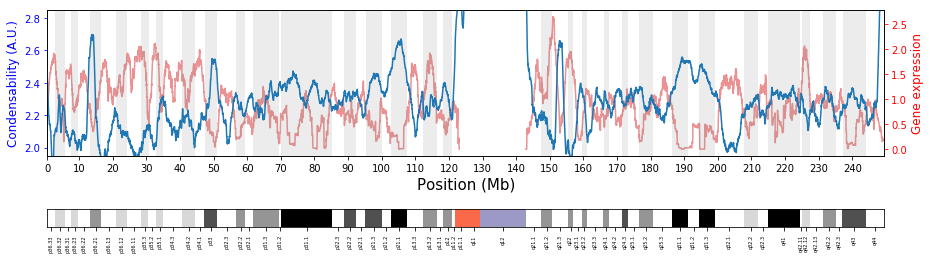

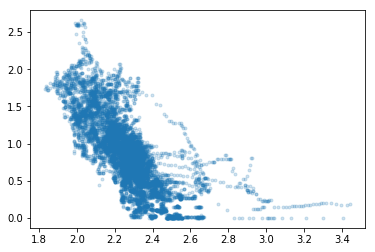

chr1
Spearman corr:-0.796302


In [24]:
### plot genome-wide data along with ideogram
## figure parameters
side_names = {'left':[(1, 'H1', 'NCP', 'sp', 8, 'score')],
              'right':['RNA']}
name_color = {(1, 'H1', 'NCP', 'sp', 8, 'score'):'tab:blue',
              'RNA':'tab:red'}
name_alpha = {(1, 'H1', 'NCP', 'sp', 8, 'score'):1,
              'RNA':0.5}
side_ylabel={'left':'Condensability (A.U.)',
             'right':'Gene expression'}
side_ycolor={'left':'blue',
             'right':'red'}
side_ylim={'left':[1.95, 2.85],
           'right':None}
#side_ylim={'left':None,
#           'right':None}
side_yscale={'left':None,
             'right':None}

## plot data in genome-wide
for chr in ['chr1']:
    name_sig = chr_exp_sig[chr]
    name_sig['RNA'] = chr_RNA_sig[chr]
    shade_wins = chr_shade_wins[chr]
    graphics.plot_genome_wide(side_names=side_names,
                              name_sig=name_sig,
                              name_color=name_color,
                              name_alpha=name_alpha,
                              side_ylabel=side_ylabel,
                              side_ycolor=side_ycolor,
                              side_ylim=side_ylim,
                              side_yscale=side_yscale,
                              xtick_locs=chr_xtick_locs[chr],
                              xtick_labels=chr_xtick_labels[chr],
                              Gtype_ideogram=chr_Gtype_ideogram[chr],
                              Gtick_locs=chr_Gtick_locs[chr],
                              Gtick_labels=chr_Gtick_labels[chr],
                              shade_wins=shade_wins,
                              fig_width=15,
                              fig_height=4,
                              height_ratios=[8, 1],
                              hspace=0.65,
                              save=False)
    
    left = side_names['left'][0]
    right = side_names['right'][0]
    X, Y = name_sig[left], name_sig[right]
    corr = statis.get_spearman_corr(X, Y)

    fig = plt.figure()
    plt.plot(X, Y, '.', alpha=0.2)
    plt.show()
    plt.close()

    print chr
    print 'Spearman corr:%f' % (corr)

In [25]:
### make bin hash functions
#chr_intdict = {}
#for chr in chr_exp_ID_value:
#    Int_dict = Interval_dict.bin_hash(bin_size,
#                                      bin_size,
#                                      genome_size[chr],
#                                      silent=True)
#    chr_intdict[chr] = Int_dict

In [26]:
### binning average of the data
#chr_exp_binID_mean = {}
#for chr in chr_exp_ID_value:
#    for exp in chr_exp_ID_value[chr]:
#        ID_value = chr_exp_ID_value[chr][exp]
        
#        Int_dict_sum = copy.deepcopy(chr_intdict[chr])
#        Int_dict_count = copy.deepcopy(chr_intdict[chr])
#        for ID, value in ID_value.items():
#            if len(ID) == 2:
#                _, pos = ID
#                Int_dict_sum.insert(pos, value)
#                Int_dict_count.insert(pos, 1)
#            elif len(ID) == 3:
#                _, st, ed = ID
#                Int_dict_sum.insert_range(st, ed, value)
#                Int_dict_count.insert_range(st, ed, 1)
#        binID_sum = Int_dict_sum.get()
#        binID_count = Int_dict_count.get()
        
#        binID_mean = {}
#        binID_st, binID_ed = 0, genome_size[chr] / bin_step
#        for binID in range(binID_st, binID_ed+1):
#            try:
#                mean = float(binID_sum[binID]) / binID_count[binID]
#            except:
#                mean = np.nan
#            binID_mean[binID] = mean

#        if chr not in chr_exp_binID_mean:
#            chr_exp_binID_mean[chr] = {}
#        if exp not in chr_exp_binID_mean[chr]:
#            chr_exp_binID_mean[chr][exp] = binID_mean

#        del Int_dict_sum, Int_dict_count
#        del binID_sum, binID_count

In [27]:
### smoothing the data by sliding window average
#chr_exp_sig = {}
#for chr in chr_exp_binID_mean:
#    for exp in chr_exp_binID_mean[chr]:
#        binID_mean = chr_exp_binID_mean[chr][exp]
#        sig = [binID_mean[binID] for binID in sorted(binID_mean.keys())]
#        sig = statis.slow_moving_average2(sig, blur_win)
#        if chr not in chr_exp_sig:
#            chr_exp_sig[chr] = {}
#        chr_exp_sig[chr][exp] = sig
